In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from joblib import dump, load
import pickle
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from ctgan import CTGAN

### Data Preprocessing

Focuse on service == http, drop columns which have the same values in all rows ('protocol_type', 'land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds', 'is_host_login', 'is_guest_login'). drop columns "index" and "flag" after dummies this column. Swap class from values "normaly" & "anomaly" to 1 & 0. 

In [6]:
#read data & use only http services
df = pd.read_csv("..\\data\\IPS\\Train_data.csv")
df = df[df['service'].str.contains('http')]
df = df[df['service'] != 'http_8001']
df = df.drop(columns=["service"])
df = df.reset_index()
df = df.drop(columns=["protocol_type"])
df = df.drop(columns=["index"])

In [ ]:
#split column flag
df_dumm = pd.get_dummies(df["flag"], prefix="flag", dtype=int)
col = df.columns.get_loc('flag')+1
for col_name in reversed(df_dumm.columns):  
    df.insert(col, col_name, df_dumm[col_name])
df = df.drop(columns=["flag"])

#drop columns with one value f.g. 1 in all rows
df['class'] = df['class'].replace({'normal': 1, 'anomaly': 0})
df = df.drop(columns=['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds',
       'is_host_login', 'is_guest_login'])
df.to_excel("D:\\ml\\xgboost-main\\data\\IPS\\http_data.xlsx")

#print column class distribution
colum = df['class']
print(colum.shape)
pd.Series(colum).value_counts().plot.bar()

In [ ]:
df.head()

### Training & Test Data

In [9]:
#X and y 
X = df.drop(columns=['class'])
y = df['class']

#split data on test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#concat X_train & y_train -> used to save files
df_train = pd.concat([X_train, y_train], axis=1)          
df_train['source'] = 'original'  
df_train.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\original_data.csv")

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\X_test.csv")

## OVERSAMPLING

### SMOTE

In [ ]:
file_path1 = "D:\\ml\\xgboost-main\\data\\IPS\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()

### BorderLine SMOTE

In [ ]:
file_path2 = "D:\\ml\\xgboost-main\\data\\IPS\\borderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
borderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
borderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    borderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()

### GAN

In [ ]:
file_path3 = "D:\\ml\\xgboost-main\\data\\IPS\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_train.columns
target_num = df_train['class'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_train[df_train['']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['class'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)
else:
    data_y0 = df_train[df_train['class']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['class'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)

balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["class"]
X_train_gan = balanced_data.drop(columns=["class"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
df_GAN["source"]="gan"
gan_data = df_GAN
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

### Models & fit_data

In [13]:
models = {
    "LR": LogisticRegression(max_iter=500, random_state=0),
    "LR_SMOTE": LogisticRegression(max_iter=1000, random_state=0),
    "LR_BrdSMOTE": LogisticRegression(max_iter=1000, random_state=0),
    "LR_GAN": LogisticRegression(max_iter=1000, random_state=0),
    
    "DT": DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, random_state=30),
    "DT_SMOTE": DecisionTreeClassifier(max_depth=12, min_samples_leaf=1, random_state=40),
    "DT_BrdSMOTE": DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, random_state=10),
    "DT_GAN": DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=10),
    
    "RF": RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=0),
    "RF_SMOTE": RandomForestClassifier(max_depth=12, min_samples_leaf=2, n_estimators=20, random_state=40),
    "RF_BrdSMOTE": RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=20, random_state=20),
    "RF_GAN": RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=20, random_state=30),
    
    "XGB": XGBClassifier(max_depth=4, subsample=0.8),
    "XGB_SMOTE": XGBClassifier(max_depth=4, subsample=0.5),
    "XGB_BrdSMOTE": XGBClassifier(max_depth=8, subsample=0.6),
    "XGB_GAN": XGBClassifier(max_depth=4, subsample=0.6),
    
    "XGB_RF": XGBRFClassifier(max_depth=12, n_estimiators=40, subsample=1, random_state=0),
    "XGB_RF_SMOTE": XGBRFClassifier(max_depth=12, n_estimiators=20, subsample=0.6, random_state=30),
    "XGB_RF_BrdSMOTE": XGBRFClassifier(max_depth=8, n_estimiators=20, subsample=0.5, random_state=10),
    "XGB_RF_GAN": XGBRFClassifier(max_depth=8, n_estimiators=60, subsample=1, random_state=0)
}


fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}

### GridSearch

In [ ]:
#time +- 140min
params = {
    #LR
    "LR": {
        'max_iter': [100, 500, 1000],       # Liczba iteracji
        'random_state': [0, 10, 20, 30, 40]}, # Losowość dla powtarzalności
    
    "LR_SMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_BrdSMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_GAN": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    #DT
    "DT": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
        'min_samples_leaf':[1,2]},              # minimalna ilosc probek lisci
    
    "DT_SMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_GAN": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    #RF
    "RF": {
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
        'random_state':[0,10,20,30,40]},         # ustalona losowość dla powtarzalności
    
    "RF_SMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},        

    "RF_BrdSMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    "RF_GAN": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    #XGB
    "XGB": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_SMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_GAN": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    #XGB_RF
    "XGB_RF": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},        # ustalona losowość dla powtarzalności
    
    "XGB_RF_SMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},    
    
    "XGB_RF_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},  
    
    "XGB_RF_GAN": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]}     
}
path_files = ["D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\precision_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\f1_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\recall_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\accuracy_metrics.txt"]
excel_file = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\results.xlsx"
excel_file1 = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\std.xlsx"
excel_file2 = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\best.xlsx"
name_sheet1 = "Arkusz1"
name_sheet2 = "Arkusz2"
results1 = []
results2 = []
results3 = []
goal = ['precision', 'recall', 'f1', 'accuracy']

for metrix1 in goal:
    for model_name, model in models.items():
        
        X_train, y_train = fit_data[model_name]
        params_ = params[model_name]
        model_Grid = GridSearchCV(model,param_grid=params_,scoring=metrix1, n_jobs=-1).fit(X_train,y_train)
            
        #save to txt file
        results1.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": model_Grid.best_score_})
        results2.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std":model_Grid.cv_results_['std_test_score'][model_Grid.best_index_]})
        results3.append({
        "Model": model_name,
        "Metric": metrix1,
        "Best":model_Grid.best_params_})
        df_results1 = pd.DataFrame(results1)
        df_results2 = pd.DataFrame(results2)
        df_results3 = pd.DataFrame(results3)
        df_save_mean = df_results1.pivot(index="Metric", columns="Model", values="Result")
        df_save_std = df_results2.pivot(index="Metric", columns="Model", values="Std")
        df_save_std2 = df_results3.pivot(index="Metric", columns="Model", values="Best")
        with pd.ExcelFile(excel_file) as w:
            df_save_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file1) as w1:
            df_save_std.to_excel(w1, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file2) as w2:
            df_save_std2.to_excel(w2, sheet_name=name_sheet1)
            
        

### CrossVal

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean=[]
results_cross_std=[]
goal = ['precision','f1','recall','accuracy']
path_files = ["D:\\ml\\xgboost-main\\reports\\IPS\\precision_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\IPS\\f1_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\IPS\\recall_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\IPS\\accuracy_metrics.txt"]

excel_file_cross = "D:\\ml\\xgboost-main\\reports\\IPS\\cross.xlsx"
excel_file_cross2 = "D:\\ml\\xgboost-main\\reports\\IPS\\cross_std.xlsx"
name_sheet1 = "Arkusz1"

#if not exist -> create
if not os.path.exists(excel_file_cross):
    empty_df = pd.DataFrame()
    empty_df.to_csv(excel_file_cross, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {excel_file_cross}')
        
if not os.path.exists(excel_file_cross2):
    empty_df = pd.DataFrame()
    empty_df.to_csv(excel_file_cross2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {excel_file_cross2}')

for metrix1, path_file in zip(goal, path_files):
    for model_name, model in models.items():
        
        X_train, y_train = fit_data[model_name]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_name}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_name} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)

        
        results_cross_mean.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_mean = pd.DataFrame(results_cross_mean)
        df_results_cross_std = pd.DataFrame(results_cross_std)
        df_save_mean = df_results_cross_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_std = df_results_cross_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_std.to_excel(w1, sheet_name=name_sheet1)

### Save Models

In [ ]:
for model_name, model in models.items():  
    name = f"D:\\ml\\xgboost-main\\models\\IPS\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

### HeatMap

In [ ]:
for model_name, model in models.items():
    
    # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
    X_train, y_train = fit_data[model_name]
    learned = model.fit(X_train, y_train)      
    y_pred = learned.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
            
    sns.heatmap(conf_mat, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
    plt.ylabel("Test", fontsize=13)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=15, pad=20)
    plt.gca().xaxis.set_label_position("top")
    plt.xlabel("Symulacja", fontsize=13)
    plt.gca().xaxis.tick_top()
    plt.savefig(f'D:\\ml\\xgboost-main\\reports\\IPS\\conf matrix\\{model_name}.png', bbox_inches="tight", dpi=200)     
    plt.show()
    plt.close()  

## UNDERSAMPLING 

### Data

In [12]:
#load data
smote_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\smote_data.csv")
boarderline_smote_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\borderlinesmote_data.csv")
gan_data = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\GAN_data.csv")
df_original = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\original_data.csv")
X_test = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\y_test.csv")
X_test = X_test.drop(columns=["Unnamed: 0"])
y_test = y_test.drop(columns=["Unnamed: 0"])
df_original = df_original.drop(columns=["Unnamed: 0"]) 

#sum up df (GAN, SMOTE & borderlineSMOTE)
data1 = pd.concat([gan_data, smote_data], axis=0, ignore_index=True)
sum_data = pd.concat([boarderline_smote_data, data1], axis=0, ignore_index=True)
sum_data = sum_data.reset_index(drop=True) 

data2 = pd.concat([boarderline_smote_data, df_original], axis=0, ignore_index=True)
sum_data_NM = pd.concat([data1, data2], axis=0, ignore_index=True)
sum_data_NM = sum_data_NM.reset_index(drop=True)

# read file with data
#with open("slownik.pkl", "rb") as plik:
#    RUS_train = pickle.load(plik)

In [ ]:
print(smote_data)
print(boarderline_smote_data)
print(gan_data)
print(df_original)
print(X_test)
print(y_test)   

### RandomUnderSampler

Sum up original: class
1    6045
0     447
Name: count, dtype: int64
Sampling Strategy for SUM UP DATA: {0: 5598, 1: 5598}


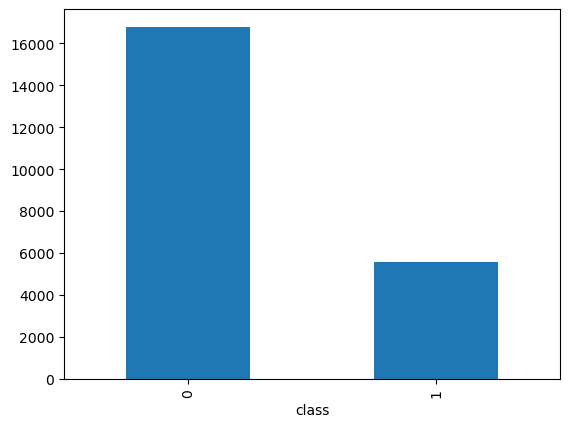

In [13]:
num_original = df_original["class"].value_counts()
print(f'Sum up original: {num_original}')
used_in_RUS = df_original[df_original["class"]==0]

#undersampling
RUS_train = {}

if num_original[0] > num_original[1]:
    #count sampling strategy
    under_samples = abs(num_original[0]-num_original[1])
    #copy only 0 from df_original 
    used_in_RUS = df_original[df_original["class"]==0]
    #used_in_RUS = used_in_RUS.drop(columns=["source"])
    count_zeros = used_in_RUS.sample(n=under_samples, random_state=42).copy()
    #count_zeros = count_zeros.drop(columns=["Unnamed: 0"])
    count_zeros_num = (count_zeros["class"] == 0).sum()
    strategy = {1: under_samples, 0: count_zeros_num}
    print(f"Sampling Strategy for SUM UP DATA: {strategy}")
    
    #split data
    RUS_data = pd.concat([sum_data, count_zeros], axis=0, ignore_index=True)
    y_under = RUS_data['class']
    X_under = RUS_data.drop(columns=["class", "source"]) 
    pd.Series(y_under).value_counts().plot.bar()
    
    #data add at the end which contains the rest 0 and 1 (~1373)
    merged = df_original.merge(count_zeros, on=df_original.columns.tolist(), how='left', indicator=True)
    rest_of_RUS = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    for i in range(1, 101):
        RUS = RandomUnderSampler(random_state=i, sampling_strategy=strategy)
        X_res, y_res = RUS.fit_resample(X_under, y_under)
        X_rest = rest_of_RUS.drop(columns=["class", "source"])
        y_rest = rest_of_RUS["class"]
        X_res = pd.concat([X_res, X_rest], axis=0, ignore_index=True)
        y_res = pd.concat([y_res, y_rest], axis=0, ignore_index=True)
        RUS_train[f'X_RUS_{i}'] = X_res, y_res
        
else: 
    #count sampling strategy
    under_samples = abs(num_original[0]-num_original[1])
    #copy only 0 from df_original 
    used_in_RUS = df_original[df_original["class"]==1]
    count_ones = used_in_RUS.sample(n=under_samples, random_state=42).copy()
    count_ones_num = (count_ones['class'] == 1).sum()
    strategy = {0: under_samples, 1: count_ones_num}
    print(f"Sampling Strategy for SUM UP DATA: {strategy}")
    
    #split data
    RUS_data = pd.concat([sum_data, count_ones], axis=0, ignore_index=True)
    y_under = RUS_data['class']
    X_under = RUS_data.drop(columns=["class", "source"]) 
    pd.Series(y_under).value_counts().plot.bar()
    
    #data add at the end which contains the rest 0 and 1 (~1373)
    merged = df_original.merge(count_ones, on=df_original.columns.tolist(), how='left', indicator=True)
    rest_of_RUS = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    for i in range(1, 101):
        RUS = RandomUnderSampler(random_state=i, sampling_strategy=strategy)
        X_res, y_res = RUS.fit_resample(X_under, y_under)
        X_rest = rest_of_RUS.drop(columns=["class", "source"])
        y_rest = rest_of_RUS["class"]
        X_res = pd.concat([X_res, X_rest], axis=0, ignore_index=True)
        y_res = pd.concat([y_res, y_rest], axis=0, ignore_index=True)
        RUS_train[f'X_RUS_{i}'] = X_res, y_res


### Data Compare

In [14]:
X_RUS_1, y_RUS_1 = RUS_train["X_RUS_25"]
columns_list = X_RUS_1.columns
X_RUS_2, y_RUS_2 = RUS_train["X_RUS_35"]

compare = datacompy.Compare(
X_RUS_1,                        # X_train or X_train_sm or X_train_bsm or X_train_gan 
X_RUS_2,
join_columns= columns_list,
abs_tol=0.0001,
rel_tol=0,
df1_name='rus25',
df2_name='rus35'
)
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns   Rows
0     rus25       37  12090
1     rus35       37  12090

Column Summary
--------------

Number of columns in common: 37
Number of columns in rus25 but not in rus35: 0
Number of columns in rus35 but not in rus25: 0

Row Summary
-----------

Matched on: duration, flag_oth, flag_rej, flag_rsto, flag_rstr, flag_s0, flag_s1, flag_s2, flag_s3, flag_sf, flag_sh, src_bytes, dst_bytes, hot, logged_in, num_compromised, root_shell, num_access_files, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate
Any duplicates on match values: Yes
Absolute Tolerance: 0.0001
Relative Tolerance: 0

### NearMiss

In [16]:
data2 = pd.concat([boarderline_smote_data, df_original], axis=0, ignore_index=True)
sum_data_NM = pd.concat([data1, data2], axis=0, ignore_index=True)
sum_data_NM = sum_data_NM.reset_index(drop=True) 

y_under_NM = sum_data_NM['class']
X_under_NM = sum_data_NM.drop(columns=["class", "source"]) 
NM = NearMiss()
X_NM, y_NM = NM.fit_resample(X_under_NM, y_under_NM)